# Continuous Control with DDGP

---

In this project, we use the Unity ML-Agents environment to demonstrate how deep deterministic policy gradient (DDPG) can be used to solve navigation problems. This is the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). Make sure you follow the steps outlined in the README file to set up the necessary packages and environment.

In this implementation, we use the one agent environment with model setup very similar to the model structure in the original DDGP paper. 

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='env\Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:',  states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Deep Deterministic Policy Gradient (DDPG)

#### Key Concept:

In the previous Navigation with DQN project, DQN succesfully learned a good policy to teach the agent to pick the best action out of 4 possible actions. However, for continuous control projects where actions are much more complex, DQN no longer works because we cannnot simply take argmax over all possible actions. 

Instead, we are applying DDPG which uses actor and critic networks to solve this problem. 

#### Actor and Critic

In DDPG, we use a seperate network to determine what the best action is for each state. This is the actor network. We use another network to model the expected value of a state + action combination. As mentioned in the DDPG paper, it is important to use targets for both actor and critic networks to help our models stablize.

For this exercise, we used network structures that are similar to those used in the original DDPG paper. 

##### Normalization
Normalization is extrememly important for this task. When state inputs have different dimensions, the differences in magnitude would cause our networks to be unstable. In this implementation, we applied the weight normalization for all non-last layers. This helped the agent learn tremendously. For more details, see `model.py`

#### DDPG Agent

Just like DQN, having a relay buffer and seperating target and current networks are two key ideas that allow the model to learn. More specifically:

1. Relay Buffer:
Instead of using (state, action, reward) tuples in their natural order, our agent stores a bunch of such tuples in a relay buffer. In each iteration, at each time step, the agent will put the new (state, action, reward) tuple in to the buffer and pull out a random batch of tuples to update the networks

2. Target Q vs. Current Q:
At each step, instead of updating the current network according to values in the current network, we use a target network that only gets updated to the current network slowly. This prevents the networks from chasing after a moving target and helps the agent to learn better. We apply this concept to both actor and critic.

##### Learning Steps
Having two networks make things slightly more complicated. Here are the major steps that happen during learning:
1. Pick the next action using target actor network
2. Obtain the corresponding Q-value estimate using target critic network
3. Update the current critic using updated target Q values by minimizing the mse between the expected local Q and target Q
4. Obtain the predicted action using current actor network
5. Update the current actor by following the action-value gradient
6. Soft update the target networks with a small fraction of the current networks

For more information on DDPG, please see `ddpg_agent.py`

### 4. Training DDGP

To deploy our agent to solve the navigation problem, we first import the agent class we wrote. When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:

agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)


In [8]:
def ddpg(n_episodes=2000, max_t=10000):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0        
        
        for t in range(max_t):

            action = agent.act(state)
            #Update the environment with our chosen action, and obtain the associated next_state, reward, done status
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0] 
            done  = env_info.local_done[0]   

            # The agent will then update the current network after a forward pass and then back-propagation of the deep network
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                break 

        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Last 100 Episodes Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")  
            
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Last 100 Episodes Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Last 100 Episodes Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break  
            
    return scores



In [9]:
scores = ddpg(n_episodes=500)



C:\Users\kathl\Desktop\Data Science\Udacity\DeepReinf\ContinuousControlWithDDPG - Copy\One_agent\ddpg_agent.py:121: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 50	Average Last 100 Episodes Score: 2.44
Episode 100	Average Last 100 Episodes Score: 4.43
Episode 150	Average Last 100 Episodes Score: 7.58
Episode 200	Average Last 100 Episodes Score: 9.95
Episode 250	Average Last 100 Episodes Score: 12.76
Episode 300	Average Last 100 Episodes Score: 17.77
Episode 350	Average Last 100 Episodes Score: 22.23
Episode 400	Average Last 100 Episodes Score: 25.80
Episode 450	Average Last 100 Episodes Score: 29.53
Episode 461	Average Last 100 Episodes Score: 30.00	Score: 32.58
Environment solved in 461 episodes!	Average Last 100 Episodes Score: 30.00


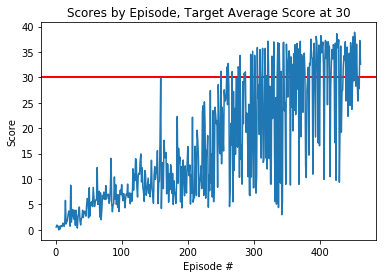

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(y = 30, linewidth=2, color='r')
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('Scores by Episode, Target Average Score at 30')

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Observe trained agent

After successfully training agent and storing the weights, we can see it in action by running the following cell. The learned agent did pretty well in reaching the target.

In [11]:

# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
    
for i in range(5):
    
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]

    score = 0

    for j in range(1000):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0] 
        reward = env_info.rewards[0] 
        done = env_info.local_done[0]
        score += reward
        state = next_state 
        if done:
            break 
    
    print("episode:", i+1, ", score:", score )
            

episode: 1 , score: 28.589999360963702
episode: 2 , score: 35.54999920539558
episode: 3 , score: 30.299999322742224
episode: 4 , score: 36.109999192878604
episode: 5 , score: 35.96999919600785


In [12]:
env.close()

### 6. Future Improvements

There are a few ways this solution can be improved. 


  
1. Use multiple agent version:  
With multiple agents, we can average the learning and hopefully achieve better results. 
  
2. Update less frequently:  
It can be seen from our score history that the learning is very volatile. One possible way to resolve this is to only step the agent after a few simulations at each time. 

3. The Deep Neural Nets have not been optimized. We did not experiement with a wide range of hype-parameters to pick and choose the best assumptions that optimize this problem.  

4. Other normalization methods:  
We can also try batch normalization to see if it achieves better results
  
5. Others: There are other methods that can be used to solve this problem. For example, Trust Region Policy Optimization (TRPO) seems to produce great results for many reinforcement tasks. 
  